In [164]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy
from ripser import ripser
from persim import plot_diagrams
from gtda.time_series import Resampler
import plotly.express as px

In [2]:
C22F002 = pd.read_csv('C22F002.csv')

In [3]:
def spectrum1(h, dt=1):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw

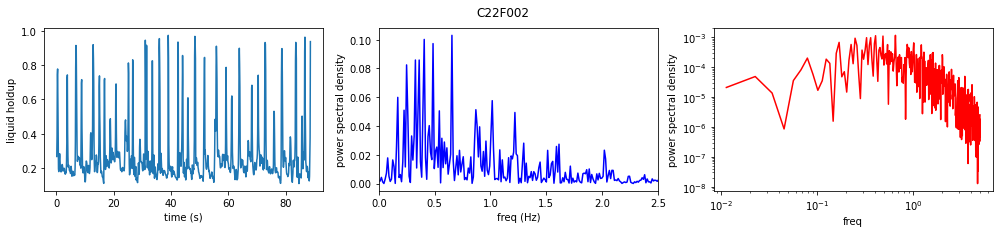

In [4]:
fig_C22F002, data = plt.subplots(1, 3, figsize=(17, 3))

fig_C22F002.suptitle('C22F002')
data[0].set_xlabel('time (s)')
data[0].set_ylabel('liquid holdup')
data[1].set_xlabel('freq (Hz)')
data[1].set_ylabel('power spectral density')
data[1].set_xlim([0,2.5])
data[2].set_xlabel('freq')
data[2].set_ylabel('power spectral density')

freqs, ps, psd = spectrum1(C22F002[C22F002.columns[1]], dt=0.1)

data[0].plot(C22F002[C22F002.columns[0]],C22F002[C22F002.columns[1]])
#data[1].loglog(freqs,psd,'r',freqs,ps,'b')
data[1].plot(freqs,psd,'b')
data[2].loglog(freqs,ps,'r')



In [5]:
type(C22F002)

pandas.core.frame.DataFrame

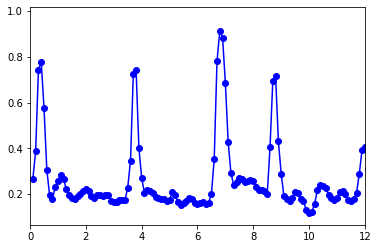

In [6]:
plt.xlim([0,12])
plt.plot(C22F002[C22F002.columns[0]],C22F002[C22F002.columns[1]], 'bo-')

In [7]:
slug_signal = C22F002.iloc[:, 1]

In [8]:
def TDAanalyze(signal, stride):

    max_time_delay = int(len(signal)/2) 
    max_embedding_dimension = int(len(signal)/20)
    print('length of signal to analyze', len(signal))
    print('max time delay', max_time_delay)
    print('max dim embedding', max_embedding_dimension)
    print('stride', stride)

    optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
        signal, max_time_delay, max_embedding_dimension, stride=stride
        )

    print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
    print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")
    
    embedding_dimension = optimal_embedding_dimension
    embedding_time_delay = optimal_time_delay
    stride = stride

    embedder = SingleTakensEmbedding(
        parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
        )

    y_signal_embedded = embedder.fit_transform(signal)

    pca = PCA(n_components=3)
    y_signal_embedded_pca = pca.fit_transform(y_signal_embedded)

    plot_point_cloud(y_signal_embedded_pca)
    
    homology_dimensions = (0, 1, 2)
    VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

    y_signal_embedded_reshaped = y_signal_embedded.reshape(1, *y_signal_embedded.shape)
 
    PH_signal = VRP.fit_transform(y_signal_embedded_reshaped)
    VRP.plot(PH_signal)
    PE_signal = PersistenceEntropy()
    features = PE_signal.fit_transform(PH_signal)

    
    return features

In [9]:
print('length of signal to analyze', len(slug_signal))

max_time_delay = 10
max_embedding_dimension = 80
stride = 1

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    slug_signal, max_time_delay, max_embedding_dimension, stride=stride
    )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")

length of signal to analyze 886
Optimal embedding time delay based on mutual information: 9
Optimal embedding dimension based on false nearest neighbors: 8


In [10]:
embedding_dimension = 8
embedding_time_delay = 9
stride = 2

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(slug_signal)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

In [11]:
homology_dimensions = (0,1,2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_slug_embedded_reshaped = y_slug_embedded.reshape(1, *y_slug_embedded.shape)
print(f"y_slug_embedded_reshaped.shape",y_slug_embedded_reshaped.shape)
print(f"y_slug_embedded.shape", y_slug_embedded.shape)


PH_slug = VRP.fit_transform(y_slug_embedded_reshaped)
VRP.plot(PH_slug)

y_slug_embedded_reshaped.shape (1, 416, 7)
y_slug_embedded.shape (416, 7)


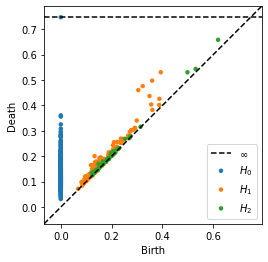

In [12]:
dgms = ripser(y_slug_embedded, maxdim=2)['dgms']
plot_diagrams(dgms, show=True)

In [13]:
PE_slug = PersistenceEntropy()
features = PE_slug.fit_transform(PH_slug)
features

array([[8.58724305, 6.61280539, 4.86099399]])

In [14]:
embedding_dimension = 20
embedding_time_delay = 5
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(slug_signal)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

In [15]:
homology_dimensions = (0,1,2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_slug_embedded_reshaped = y_slug_embedded.reshape(1, *y_slug_embedded.shape)
print(f"y_slug_embedded_reshaped.shape",y_slug_embedded_reshaped.shape)
print(f"y_slug_embedded.shape", y_slug_embedded.shape)


PH_slug = VRP.fit_transform(y_slug_embedded_reshaped)
VRP.plot(PH_slug)

y_slug_embedded_reshaped.shape (1, 856, 7)
y_slug_embedded.shape (856, 7)


In [16]:
PE_slug = PersistenceEntropy()
features = PE_slug.fit_transform(PH_slug)
features

array([[9.56614713, 8.00354027, 5.95416828]])

In [17]:
TDAanalyze(slug_signal, 1)

length of signal to analyze 886
max time delay 443
max dim embedding 44
stride 1
Optimal embedding time delay based on mutual information: 11
Optimal embedding dimension based on false nearest neighbors: 8


array([[9.5207678 , 8.02061376, 6.37559213]])

In [18]:
TDAanalyze(slug_signal, 2)

length of signal to analyze 886
max time delay 443
max dim embedding 44
stride 2
Optimal embedding time delay based on mutual information: 11
Optimal embedding dimension based on false nearest neighbors: 10


array([[8.48456645, 6.72659428, 4.76899454]])

Albeit there is very low persistence in this timeseries, the homology class H_2 has extremely low entropy. This is sign of order in the high dimensional structure.

In [19]:
C22F002_downsampled_2 = C22F002.iloc[::2, :]
C22F002_downsampled_2

time(s)   liquid holdup 
0        0.1         0.267684
2        0.3         0.744619
4        0.5         0.575393
6        0.7         0.195540
8        0.9         0.230115
..       ...              ...
876     87.7         0.173447
878     87.9         0.154947
880     88.1         0.163688
882     88.3         0.152851
884     88.5         0.376441

[443 rows x 2 columns]

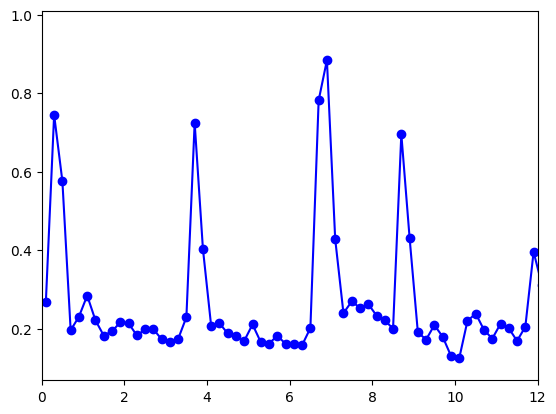

In [20]:
plt.xlim([0,12])
plt.plot(C22F002_downsampled_2[C22F002_downsampled_2.columns[0]],C22F002_downsampled_2[C22F002_downsampled_2.columns[1]], 'bo-')

In [21]:
slug_signal_down = C22F002_downsampled_2.iloc[:, 1]
slug_signal_down.size
TDAanalyze(slug_signal_down, 2)

length of signal to analyze 443
max time delay 221
max dim embedding 22
stride 2
Optimal embedding time delay based on mutual information: 8
Optimal embedding dimension based on false nearest neighbors: 9


array([[7.37728829, 6.05979254, 4.75273863]])

length of signal to analyze 296
max time delay 148
max dim embedding 14
stride 1
Optimal embedding time delay based on mutual information: 5
Optimal embedding dimension based on false nearest neighbors: 8


array([[7.84817101, 6.05865544, 3.52692519]])

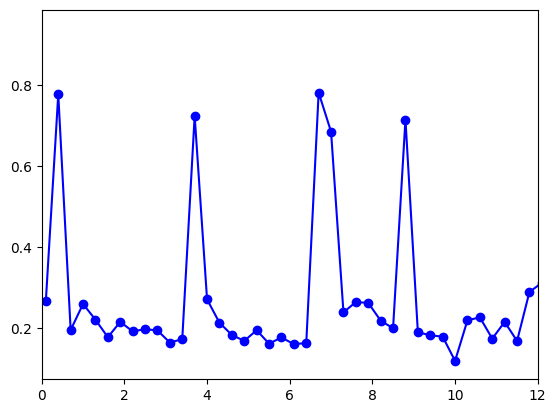

In [22]:
C22F002_downsampled_3 = C22F002.iloc[::3, :]
slug_signal_down = C22F002_downsampled_3.iloc[:, 1]
plt.xlim([0,12])
plt.plot(C22F002_downsampled_3[C22F002_downsampled_3.columns[0]],C22F002_downsampled_3[C22F002_downsampled_3.columns[1]], 'bo-')
TDAanalyze(slug_signal_down, 1)

In [23]:
embedding_dimension = 5
embedding_time_delay = 8
stride = 2

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(slug_signal_down)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

In [24]:
homology_dimensions = (0,1,2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_slug_embedded_reshaped = y_slug_embedded.reshape(1, *y_slug_embedded.shape)
print(f"y_slug_embedded_reshaped.shape",y_slug_embedded_reshaped.shape)
print(f"y_slug_embedded.shape", y_slug_embedded.shape)


PH_slug = VRP.fit_transform(y_slug_embedded_reshaped)
VRP.plot(PH_slug)

y_slug_embedded_reshaped.shape (1, 143, 3)
y_slug_embedded.shape (143, 3)


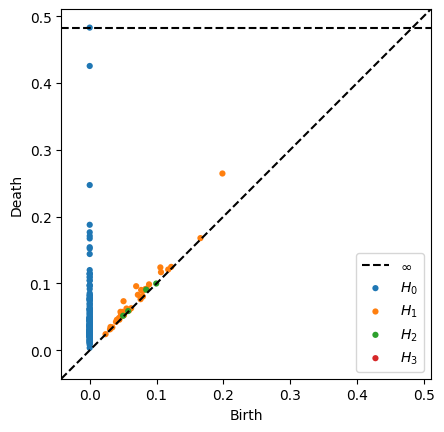

In [25]:
dgms = ripser(y_slug_embedded, maxdim=3)['dgms']
plot_diagrams(dgms, show=True)

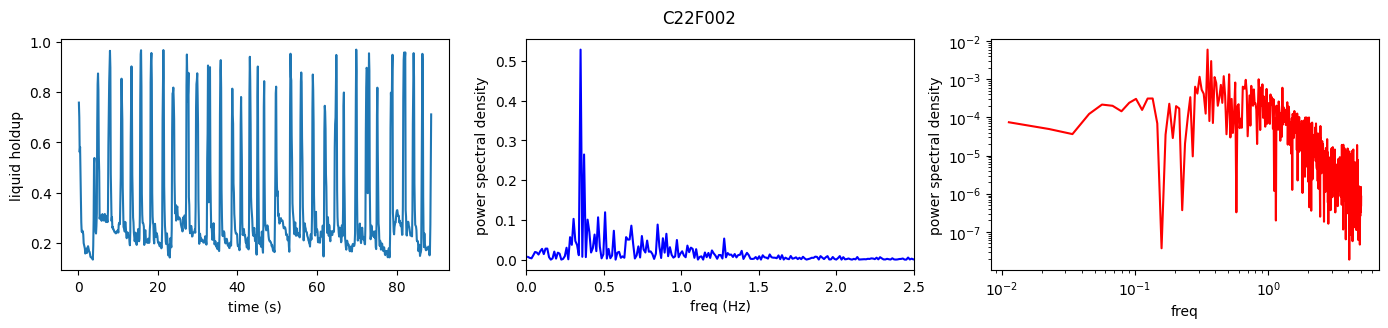

In [26]:
C22F046 = pd.read_csv('C22F046.csv')

fig_C22F046, data = plt.subplots(1, 3, figsize=(17, 3))

fig_C22F046.suptitle('C22F002')
data[0].set_xlabel('time (s)')
data[0].set_ylabel('liquid holdup')
data[1].set_xlabel('freq (Hz)')
data[1].set_ylabel('power spectral density')
data[1].set_xlim([0,2.5])
data[2].set_xlabel('freq')
data[2].set_ylabel('power spectral density')

freqs, ps, psd = spectrum1(C22F046[C22F046.columns[1]], dt=0.1)

data[0].plot(C22F046[C22F046.columns[0]],C22F046[C22F046.columns[1]])
#data[1].loglog(freqs,psd,'r',freqs,ps,'b')
data[1].plot(freqs,psd,'b')
data[2].loglog(freqs,ps,'r')

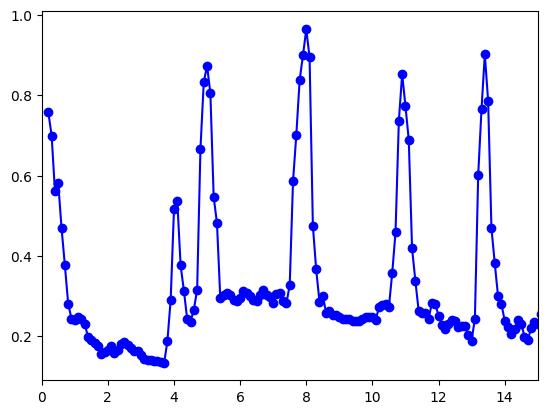

In [27]:
plt.xlim([0,15])
plt.plot(C22F046[C22F046.columns[0]],C22F046[C22F046.columns[1]], 'bo-')

In [163]:
fig = px.line(title='C22F002 vs C22F046')
fig.add_scatter(x=C22F046.iloc[:, 0], y=C22F046.iloc[:, 1], name='C22F046', mode='lines+markers')
fig.add_scatter(x=C22F002.iloc[:, 0], y=C22F002.iloc[:, 1], name='C22F002', mode='lines+markers')
fig.show()

In [115]:
C22F046_signal = C22F046.iloc[:, 1]
TDAanalyze(C22F046_signal, 1)

length of signal to analyze 885
max time delay 442
max dim embedding 44
stride 1
Optimal embedding time delay based on mutual information: 10
Optimal embedding dimension based on false nearest neighbors: 12


array([[9.51424081, 7.8009685 , 6.0110168 ]])

In [116]:
embedding_dimension = 12
embedding_time_delay = 10
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(C22F046_signal)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

In [117]:
homology_dimensions = (0,1,2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_slug_embedded_reshaped = y_slug_embedded.reshape(1, *y_slug_embedded.shape)
print(f"y_slug_embedded_reshaped.shape",y_slug_embedded_reshaped.shape)
print(f"y_slug_embedded.shape", y_slug_embedded.shape)


PH_slug = VRP.fit_transform(y_slug_embedded_reshaped)
VRP.plot(PH_slug)

y_slug_embedded_reshaped.shape (1, 775, 12)
y_slug_embedded.shape (775, 12)


In [118]:
PE_slug = PersistenceEntropy()
features = PE_slug.fit_transform(PH_slug)
features

array([[9.51424081, 7.8009685 , 6.0110168 ]])

In [41]:
embedding_dimension = 10
embedding_time_delay = 1
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(C22F046_signal)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

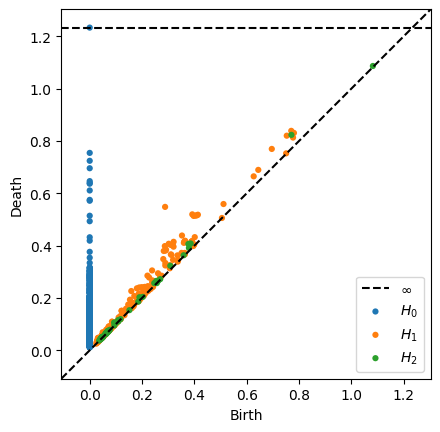

In [42]:
dgms = ripser(y_slug_embedded, maxdim=2)['dgms']
plot_diagrams(dgms, show=True)

In [43]:
homology_dimensions = (0,1,2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_slug_embedded_reshaped = y_slug_embedded.reshape(1, *y_slug_embedded.shape)
print(f"y_slug_embedded_reshaped.shape",y_slug_embedded_reshaped.shape)
print(f"y_slug_embedded.shape", y_slug_embedded.shape)


PH_slug = VRP.fit_transform(y_slug_embedded_reshaped)
VRP.plot(PH_slug)

y_slug_embedded_reshaped.shape (1, 876, 10)
y_slug_embedded.shape (876, 10)


In [44]:
PE_slug = PersistenceEntropy()
features = PE_slug.fit_transform(PH_slug)
features

array([[9.30442609, 7.25567452, 4.90054526]])

In [45]:
embedding_dimension = 12
embedding_time_delay = 2
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(C22F046_signal)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

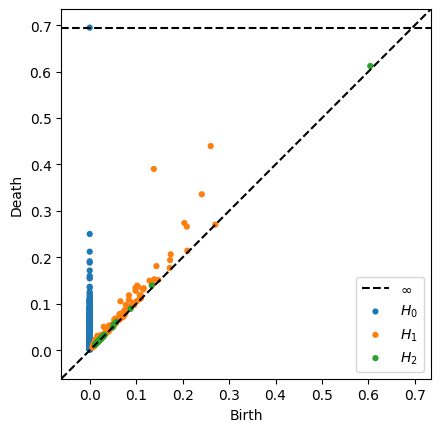

In [46]:
dgms = ripser(y_slug_embedded, maxdim=2)['dgms']
plot_diagrams(dgms, show=True)

In [47]:
homology_dimensions = (0,1,2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_slug_embedded_reshaped = y_slug_embedded.reshape(1, *y_slug_embedded.shape)
print(f"y_slug_embedded_reshaped.shape",y_slug_embedded_reshaped.shape)
print(f"y_slug_embedded.shape", y_slug_embedded.shape)


PH_slug = VRP.fit_transform(y_slug_embedded_reshaped)
VRP.plot(PH_slug)

y_slug_embedded_reshaped.shape (1, 881, 3)
y_slug_embedded.shape (881, 3)


In [48]:
PE_slug = PersistenceEntropy()
features = PE_slug.fit_transform(PH_slug)
features

array([[9.08873643, 6.5280557 , 4.63189739]])

In [49]:
embedding_dimension = 10
embedding_time_delay = 3
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(C22F046_signal)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

In [51]:
embedding_dimension = 10
embedding_time_delay = 2
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(C22F046_signal)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

In [52]:
homology_dimensions = (0,1,2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_slug_embedded_reshaped = y_slug_embedded.reshape(1, *y_slug_embedded.shape)
print(f"y_slug_embedded_reshaped.shape",y_slug_embedded_reshaped.shape)
print(f"y_slug_embedded.shape", y_slug_embedded.shape)


PH_slug = VRP.fit_transform(y_slug_embedded_reshaped)
VRP.plot(PH_slug)

y_slug_embedded_reshaped.shape (1, 439, 5)
y_slug_embedded.shape (439, 5)


In [53]:
PE_slug = PersistenceEntropy()
features = PE_slug.fit_transform(PH_slug)
features

array([[8.24846436, 5.16503827, 2.91567409]])

In [165]:
period = 3
periodicSampler = Resampler(period=period)

C22F046_signal = C22F046.iloc[:, 1]
C22F046_time = C22F046.iloc[:, 0]

# throw away the first 100 points
C22F046_signal = C22F046_signal[100:]
C22F046_time = C22F046_time[100:]

X_sampled, y_sampled = periodicSampler.fit_transform_resample(C22F046_time, C22F046_signal)

fig = px.line(title='Trajectory of the Lorenz solution, projected along the z-axis and resampled every 10h')
#fig.add_scatter(y=C22F046_signal, name='C22F046_signal')
fig.add_scatter(y=y_sampled, name='y_sampled', mode='lines+markers')
fig.show()

In [166]:
TDAanalyze(y_sampled, 1)

length of signal to analyze 262
max time delay 131
max dim embedding 13
stride 1
Optimal embedding time delay based on mutual information: 4
Optimal embedding dimension based on false nearest neighbors: 9


array([[7.74894815, 5.86068559, 3.68907585]])

In [184]:
embedding_dimension = 9
embedding_time_delay = 2
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(y_sampled)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

In [185]:
homology_dimensions = (0,1,2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_slug_embedded_reshaped = y_slug_embedded.reshape(1, *y_slug_embedded.shape)
print(f"y_slug_embedded_reshaped.shape",y_slug_embedded_reshaped.shape)
print(f"y_slug_embedded.shape", y_slug_embedded.shape)


PH_slug = VRP.fit_transform(y_slug_embedded_reshaped)
VRP.plot(PH_slug)

y_slug_embedded_reshaped.shape (1, 254, 5)
y_slug_embedded.shape (254, 5)


In [186]:
PE_slug = PersistenceEntropy()
features = PE_slug.fit_transform(PH_slug)
features

array([[ 7.77597423,  4.8602471 , -1.        ]])

In [107]:
TDAanalyze(y_sampled, 1)

length of signal to analyze 177
max time delay 88
max dim embedding 8
stride 1
Optimal embedding time delay based on mutual information: 2
Optimal embedding dimension based on false nearest neighbors: 4


array([[7.22952176, 4.57956027, 1.5007127 ]])

It is pretty clear that there is not a high persistency in these data, probably because the pattern is not really periodic (not quasi-periodic), rather is very chaotic. In the equations from Perea, it is assumed that the time serie could be expanded in Fourier series. Maybe, these data are not.... 

In [228]:
embedding_dimension = 9
embedding_time_delay = 2
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(y_sampled)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

In [229]:
homology_dimensions = (0,1,2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_slug_embedded_reshaped = y_slug_embedded.reshape(1, *y_slug_embedded.shape)
print(f"y_slug_embedded_reshaped.shape",y_slug_embedded_reshaped.shape)
print(f"y_slug_embedded.shape", y_slug_embedded.shape)


PH_slug = VRP.fit_transform(y_slug_embedded_reshaped)
VRP.plot(PH_slug)

y_slug_embedded_reshaped.shape (1, 254, 5)
y_slug_embedded.shape (254, 5)


In [347]:
def MaxPers(PH):
    arrH0 = []
    arrH2 = []
    arrH1 = []
    for triplet in PH:
        for i in range(len(triplet)):
            if triplet[i][2] == 0: arrH0.append(triplet[i][1])
            if triplet[i][2] == 1: arrH1.append(triplet[i][1])
            if triplet[i][2] == 2: arrH2.append(triplet[i][1])
    
    print('Max persistence class H_0:', max(arrH0))
    print('Max persistence class H_1:', max(arrH1))
    print('Max persistence class H_2:', max(arrH2))

    return 

In [348]:
MaxPers(PH_slug)

Max persistence class H_0: 0.3369234800338745
Max persistence class H_1: 0.5302571058273315
Max persistence class H_2: 0.0


In [216]:
def TDAConvergenceDim(signal, stride):

    max_time_delay = int(len(signal)/2) 
    max_embedding_dimension = int(len(signal)/20)
    print('length of signal to analyze', len(signal))
    print('max time delay', max_time_delay)
    print('max dim embedding', max_embedding_dimension)
    print('stride', stride)

    optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
        signal, max_time_delay, max_embedding_dimension, stride=stride
        )

    print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
    print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")
    
    ndim_max = optimal_embedding_dimension + 2
    features_list = []
    
    ndim = 3
    
    while ndim <= ndim_max:
    
        embedding_dimension = ndim
        embedding_time_delay = optimal_time_delay
        stride = stride

        embedder = SingleTakensEmbedding(
            parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
            )

        y_signal_embedded = embedder.fit_transform(signal)

        pca = PCA(n_components=3)
        y_signal_embedded_pca = pca.fit_transform(y_signal_embedded)

        plot_point_cloud(y_signal_embedded_pca)

        homology_dimensions = (0, 1, 2)
        VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

    # the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

        y_signal_embedded_reshaped = y_signal_embedded.reshape(1, *y_signal_embedded.shape)

        PH_signal = VRP.fit_transform(y_signal_embedded_reshaped)
        VRP.plot(PH_signal)
        PE_signal = PersistenceEntropy()
        features = PE_signal.fit_transform(PH_signal)
        
        features_to_append = ['dim', ndim, 'entropy', features]
        
        features_list.append(features_to_append)
        ndim += 1
        
    return features_list

In [222]:
def TDAConvergenceDelay(signal, stride):

    max_time_delay = int(len(signal)/2) 
    max_embedding_dimension = int(len(signal)/20)
    print('length of signal to analyze', len(signal))
    print('max time delay', max_time_delay)
    print('max dim embedding', max_embedding_dimension)
    print('stride', stride)

    optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
        signal, max_time_delay, max_embedding_dimension, stride=stride
        )

    print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
    print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")
    
    delay_max = optimal_time_delay + 4
    
    features_list = []
    
    delay = 1
    
    while delay <= delay_max:
    
        embedding_dimension = optimal_embedding_dimension
        embedding_time_delay = delay
        stride = stride

        embedder = SingleTakensEmbedding(
            parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
            )

        y_signal_embedded = embedder.fit_transform(signal)

        pca = PCA(n_components=3)
        y_signal_embedded_pca = pca.fit_transform(y_signal_embedded)

        plot_point_cloud(y_signal_embedded_pca)

        homology_dimensions = (0, 1, 2)
        VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

    # the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

        y_signal_embedded_reshaped = y_signal_embedded.reshape(1, *y_signal_embedded.shape)

        PH_signal = VRP.fit_transform(y_signal_embedded_reshaped)
        VRP.plot(PH_signal)
        PE_signal = PersistenceEntropy()
        features = PE_signal.fit_transform(PH_signal)
        
        features_to_append = ['delay', delay, 'entropy', features]
        
        features_list.append(features_to_append)
        delay += 1
        
    return features_list

In [218]:
TDAConvergenceDim(y_sampled, stride)

length of signal to analyze 262
max time delay 131
max dim embedding 13
stride 1
Optimal embedding time delay based on mutual information: 4
Optimal embedding dimension based on false nearest neighbors: 9


[['dim', 3, 'entropy', array([[7.72500681, 4.46386693, 0.94644739]])],
 ['dim', 4, 'entropy', array([[7.72500681, 4.46386693, 0.94644739]])],
 ['dim', 5, 'entropy', array([[7.72500681, 4.46386693, 0.94644739]])],
 ['dim', 6, 'entropy', array([[7.72500681, 4.46386693, 0.94644739]])],
 ['dim', 7, 'entropy', array([[7.72500681, 4.46386693, 0.94644739]])],
 ['dim', 8, 'entropy', array([[7.72500681, 4.46386693, 0.94644739]])],
 ['dim', 9, 'entropy', array([[7.74894815, 5.86068559, 3.68907585]])],
 ['dim', 10, 'entropy', array([[7.74894815, 5.86068559, 3.68907585]])],
 ['dim', 11, 'entropy', array([[7.74894815, 5.86068559, 3.68907585]])]]

In [223]:
TDAConvergenceDelay(y_sampled, stride)

length of signal to analyze 262
max time delay 131
max dim embedding 13
stride 1
Optimal embedding time delay based on mutual information: 4
Optimal embedding dimension based on false nearest neighbors: 9


[['delay', 1, 'entropy', array([[7.83421972, 5.34148752, 1.74292269]])],
 ['delay', 2, 'entropy', array([[ 7.77597423,  4.8602471 , -1.        ]])],
 ['delay', 3, 'entropy', array([[7.79100683, 5.72903563, 1.38923959]])],
 ['delay', 4, 'entropy', array([[7.74894815, 5.86068559, 3.68907585]])],
 ['delay', 5, 'entropy', array([[7.74894815, 5.86068559, 3.68907585]])],
 ['delay', 6, 'entropy', array([[7.74894815, 5.86068559, 3.68907585]])],
 ['delay', 7, 'entropy', array([[7.74894815, 5.86068559, 3.68907585]])],
 ['delay', 8, 'entropy', array([[7.74894815, 5.86068559, 3.68907585]])]]